# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
#how many unique articles each user interacts with on average?
dist = df.groupby(by='email').article_id.value_counts()
pd.DataFrame(dist.describe())

,article_id
count,33669.000000
mean,1.365529
std,1.175020
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,42.000000


In [4]:
# Fill in the median and maximum number of user_article interactios below
median_val = round(df.email.value_counts().median()) # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.email.value_counts()[0] # The maximum number of user-article interactions by any 1 user is ______.

median_val, max_views_by_user

(3, 364)

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [5]:
# Find and explore duplicate articles
print(f"there are {df_content.article_id.duplicated().sum()} duplicates in df_content")

there are 5 duplicates in df_content


In [6]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates('article_id', keep='first', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [7]:
print(f"there are {df.email.nunique()} unique users in df")
print(f"there are {df.article_id.nunique()} unique articles in df")
print(f'there are {df.shape[0]} user-articles interactions')

there are 5148 unique users in df
there are 714 unique articles in df
there are 45993 user-articles interactions


In [8]:
# are there Nans in email column - aka null values for users? 
df.email.apply(lambda x: isinstance(x, float)).sum()

17

In [9]:
#catching nans
nans_idx = []
for em, idx in zip(df.email, df.index):
    try:
        tmp = len(em)
    except TypeError:
        print(em, idx) 
        nans_idx.append(idx)

nan 25131
nan 29758
nan 29759
nan 29760
nan 29761
nan 35264
nan 35276
nan 35277
nan 35278
nan 35279
nan 35280
nan 35281
nan 35282
nan 35283
nan 35284
nan 42749
nan 42750


In [10]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [11]:
most_viewed_article_id = pd.DataFrame(df.article_id.value_counts()).reset_index().iloc[0, 0].astype(str) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = pd.DataFrame(df.article_id.value_counts()).reset_index().iloc[0, 1].astype(int) # The most viewed article in the dataset was viewed how many times?

most_viewed_article_id, max_views

('1429.0', 937)

In [12]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [13]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [338]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    #group by article_id and count number of recurring titles 
    top_articles = df.groupby(by='article_id').title.value_counts().sort_values(ascending=False)[:n]
    
    #access 'title' in MultiIndex and convert to list
    top_articles_titles = top_articles.index.get_level_values('title').tolist()
    return top_articles_titles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    #group by article_id and count number of recurring titles 
    top_articles = df.groupby(by='article_id').title.value_counts().sort_values(ascending=False)[:n]
     
    #access 'article_id' in MultiIndex and convert to list
    top_articles_id = top_articles.index.get_level_values('article_id').tolist()
 
    return  top_articles_id # Return the top article ids

In [340]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [341]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [17]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df['views'] = 1
    user_item = df.groupby(['user_id', 'article_id']).views.min().unstack()
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [18]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [249]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    dot_prod_user = np.dot(user_item.loc[user_id, :], user_item.T)
        
    # sort by similarity
    most_similar_ind = dot_prod_user.argsort(kind='mergesort')[::-1]

    # create list of just the ids
    most_similar_users = np.array(df.iloc[most_similar_ind, ]['user_id'])

    # remove the own user's id
    most_similar_users = most_similar_users[most_similar_users != user_id].tolist()     

       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [250]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [1117, 1080, 20, 734, 35, 765, 5, 1180, 33, 103]
The 5 most similar users to user 3933 are: [1117, 1, 1080, 20, 734]
The 3 most similar users to user 46 are: [1180, 33, 1080]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [251]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    df.article_id = df.article_id.astype(str)
    article_names = []

    for art_id in article_ids:
        
        #taking the first one we encounter (because there could be many interactions with the same article in df)
        article_name = df[df['article_id'] == art_id]['title']
        if article_name.size > 1:
            article_name = article_name.tolist()[0]
        article_names.append(article_name)
    
    return article_names # Return the article names associated with list of article ids

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = list(set(df[df.user_id == user_id].article_id.values))
    article_names = get_article_names(article_ids)
        
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    #get_user_articles returns two values - article_ids and article_names. User [0] for article_ids
    this_user_art_ids = get_user_articles(user_id)[0]
    
    most_similar_users = find_similar_users(user_id)
    
    recs_list = []
    
    for similar_user in most_similar_users:
        similar_user_art_ids = get_user_articles(similar_user)[0]
        
        #return article_ids that user hasn't seen before
        recs_ids = list(np.setdiff1d(similar_user_art_ids, this_user_art_ids))            
        recs_list.append(recs_ids)
        
        recs_ids = sum(recs_list, [])

        if len(recs_ids) > 11:
            break
        
    
    return recs_ids[:m] # return your recommendations for this user_id    

In [252]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['use decision optimization to schedule league games',
 'i am not a data scientist – ibm watson data lab',
 'using machine learning to predict parking difficulty',
 '8170    data science expert interview: dez blanchfield...\nName: title, dtype: object',
 'some random weekend reading',
 "a kaggler's guide to model stacking in practice",
 'using github for project control in dsx',
 'predicting gentrification using longitudinal census data',
 'housing (2015): united states demographic measures',
 'self-service data preparation with ibm data refinery']

In [776]:
# to make sense out of our recs, let's see what articles user 1 iteracted with :
get_article_names(get_user_articles(1)[0])

['working with ibm cloud object storage in r',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'python if statements explained (python for data science basics #4)',
 'predict loan applicant behavior with tensorflow neural networking',
 'tensorflow quick tips',
 'country statistics: life expectancy at birth',
 'welcome to pixiedust',
 'visualize car data with brunel',
 'shiny 0.13.0',
 'use deep learning for image classification',
 'time series prediction using recurrent neural networks (lstms)',
 'classify tumors with machine learning',
 'introduction to market basket analysis in\xa0python',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'new shiny cheat sheet and video tutorial',
 'putting a human face on machine learning',
 'tidyverse practice: mapping large european cities',
 'access db2 warehouse on cloud and db2 with python',
 'using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'python for 

In [253]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [289]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
  
    # compute similarity of each user to the provided user
    dot_prod_user = np.dot(user_item.loc[user_id, :], user_item.T)
    # compute num_interactions for each user
    num_interactions = np.array(user_item.sum(axis=1))
        
    # sort by similarity
    #most_similar_ind = dot_prod_user.argsort(kind='mergesort')[::-1]
    #most_similar_val = np.sort(dot_prod_user, kind='mergesort')[::-1]
    most_similar_ind = dot_prod_user.argsort()[::-1]
    most_similar_val = np.sort(dot_prod_user)[::-1]
   
    # sort num_interactions by the same order as most_similar_ind
    num_interactions_ordered = num_interactions[most_similar_ind]
    
    # create list of just the ids
    most_similar_users = np.array(df.iloc[most_similar_ind, ]['user_id'])
    
    neighbors_df = pd.DataFrame({"neighbor_id": most_similar_users, "similarity": most_similar_val,
                                 "num_iteractions": num_interactions_ordered})
    neighbors_df.sort_values(by=['similarity', 'num_iteractions'], ascending=False, inplace=True)
    
    #remove the user_id for whom recs are made from the neighbors_df
    this_user_idx = neighbors_df[neighbors_df.neighbor_id == user_id].index
    neighbors_df.drop(this_user_idx, axis=0, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    article_views = pd.DataFrame(user_item.sum(axis=0)).reset_index()
    article_views.columns = ['article_id', 'views']
    article_views.article_id = article_views.article_id.astype(str)

    #get_user_articles returns two values - article_ids and article_names. User [0] for article_ids
    this_user_art_ids = get_user_articles(user_id)[0]
    
    
    nearest_neighbors = get_top_sorted_users(user_id).neighbor_id.values
    
    recs_list = []
    
    for neighbor in nearest_neighbors:
        neighbor_art_ids = get_user_articles(neighbor)[0]
        
        #return article_ids that user hasn't seen before
        recs_ids = list(np.setdiff1d(neighbor_art_ids, this_user_art_ids))            
        recs_list.append(recs_ids)
        
        recs_ids = sum(recs_list, [])

        if len(recs_ids) > 11:
            break
        
    recs = recs_ids[:m]
    
    #sort our recs (which are article ids) by those with the most total views
    recs = article_views[article_views.article_id.isin(recs)].sort_values(by='views', ascending=False).article_id.values
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [290]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1162.0' '1172.0' '1163.0' '1296.0' '108.0' '1176.0' '1184.0' '1158.0'
 '1051.0' '1286.0']

The top 10 recommendations for user 20 are the following article names:
['analyze energy consumption in buildings', 'apache spark lab, part 3: machine learning', 'analyze open data sets with spark & pixiedust', 'fortune 100 companies', '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object', 'build a python app on the streaming analytics service', 'city population by sex, city and city type', 'airbnb data for analytics: washington d.c. reviews', 'a tensorflow regression model to predict house values', 'environment statistics database - water']


In [775]:
# to make sense out of our recs, let's see what articles user 20 iteracted with :
get_article_names(get_user_articles(20)[0])

['self-service data preparation with ibm data refinery',
 'housing (2015): united states demographic measures',
 'use the cloudant-spark connector in python notebook']

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [322]:
### Tests with a dictionary of results
# Find the user that is most similar to user 1
user1_most_sim = get_top_sorted_users(1).iloc[0, :].neighbor_id.astype(int)
 
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).iloc[9, :].neighbor_id.astype(int)

In [632]:
user1_most_sim, user131_10th_sim

(1117, 471)

# THE PROVIDED ANSWERS ARE WRONG! See justification below

In [281]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

TypeError: 'numpy.int64' object is not iterable

## Finding mistake in sol_5_test

the first test asks to find the closest user for user 1. Answer: 3933 <br>
The second test asks to find the 10th closest user to user 131. Answer: 242

In [326]:
dot_prod_user = np.dot(user_item.loc[1, :], user_item.T)
# compute num_interactions for each user
num_interactions = np.array(user_item.sum(axis=1))

# sort by similarity
most_similar_ind = dot_prod_user.argsort()[::-1]
print("most_similar_ind", most_similar_ind)
most_similar_val = np.sort(dot_prod_user)[::-1]
print("most_similar_val", most_similar_val)

# sort num_interactions by the same order as most_similar_ind
num_interactions_ordered = num_interactions[most_similar_ind]

# create list of just the ids
most_similar_users = np.array(df.iloc[most_similar_ind, ]['user_id'])
print("most_similar_users", most_similar_users)

most_similar_ind [   0 3932   22 ... 2915 2910 2574]
most_similar_val [36. 35. 17. ...  0.  0.  0.]
most_similar_users [   1 1117   20 ...  733  797  558]


From above we can see that in order to get the 'right' answer as specified in the solution (answer=3933) we need to discard the first value in most_similar_ind which is 0 (this is because it is the index of this user) and add 1 to the next index. However, it is not the same as the user_id! It is also not the index of the second best user, which is 3932 and not 3933! 

In [327]:
dot_prod_user = np.dot(user_item.loc[131, :], user_item.T)
# compute num_interactions for each user
num_interactions = np.array(user_item.sum(axis=1))

# sort by similarity
#most_similar_ind = dot_prod_user.argsort(kind='mergesort')[::-1]
#most_similar_val = np.sort(dot_prod_user, kind='mergesort')[::-1]
most_similar_ind = dot_prod_user.argsort()[::-1][:11]
print("most_similar_ind", most_similar_ind)
most_similar_val = np.sort(dot_prod_user)[::-1][:11]
print("most_similar_val", most_similar_val)

# sort num_interactions by the same order as most_similar_ind
num_interactions_ordered = num_interactions[most_similar_ind]

# create list of just the ids
most_similar_users = np.array(df.iloc[most_similar_ind, ]['user_id'])[:11]
print("most_similar_users", most_similar_users)

most_similar_ind [ 130 3869 3781   22 4458  202   97 3763 3696   48  241]
most_similar_val [75. 74. 39. 38. 33. 33. 29. 29. 29. 29. 25.]
most_similar_users [   5  765 1080   20  734   35   23  471 1055   35   71]


We see the same pattern repeat here as well - in order to get to the solution answer (answer=242) we need to discard the first index 130 and adds 1 to the 10th index which is 241. However, this is wrong! We already sorted the values and we can't just add 1 to get to the next best index.

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Since we don't have any information about the new user, the most logical thing would be to provide the list of the most popular articles on the platform which we implemented in the first step (so called ranked-based or knowledge based recommendations. As we learn more about the preferences of the user, we can make him/her more personalized recommendations later.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [343]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here

In [344]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

# 0. Preparing dataset

I will combine information from all three features - doc_body, doc_description, doc_full_name. However, because the content of the article itself was parsed really bad, doc_body has low quality. At the same time, information from doc_full_name and doc_description is really not sufficient to discriminate well between articles based on content. The title of the article (doc_full_name) might be really short, while doc_description might be either missing or apruptly end and might not include the important words. Hence, the quality of our recommendations will not be high. <br>

As a result, we are dealing here with **GIGA** - Garbage In, Garbage Out.

In [1364]:
# example of bad description that ends abruptly
df_content.doc_description[7]

'For a company like Slack that strives to be as data-driven as possible, understanding how our users use our product is essential. The Data Engineering team at Slack works to provide an ecosystem to…'

In [1371]:
# example of short article title
df_content.doc_full_name[7]

'Data Wrangling at Slack'

In [1032]:
# turns out that df_content has old index with loopholes, let's reset it
df_content = df_content.reset_index(drop=True)

In [1033]:
# turns out there are some articles without descriptions and these have Nans in them. 
# So let's change Nans to " " string.
df_content['doc_full_name'].fillna(" ", inplace=True)
df_content['doc_description'].fillna(" ", inplace=True)
df_content['doc_body'].fillna(" ", inplace=True)

In [1321]:
#combining doc_full_name, doc_description, doc_body
df_content['content'] = df_content['doc_full_name'] + ". " + df_content['doc_description'] + ". " + df_content['doc_body']

In [1322]:
df_cont = df_content[['article_id', 'content', 'doc_full_name']]
df_cont.head()

,article_id,content,doc_full_name
0,0,Detect Malfunctioning IoT Sensors with Streami...,Detect Malfunctioning IoT Sensors with Streami...
1,1,Communicating data science: A guide to present...,Communicating data science: A guide to present...
2,2,"This Week in Data Science (April 18, 2017). He...","This Week in Data Science (April 18, 2017)"
3,3,DataLayer Conference: Boost the performance of...,DataLayer Conference: Boost the performance of...
4,4,Analyze NY Restaurant data using Spark in DSX....,Analyze NY Restaurant data using Spark in DSX


In [1323]:
#checking if there are nans 
nans_idx = []
for c, idx in zip(df_cont.content, df_cont.index):
    try:
        tmp = len(c)
    except TypeError:
        print(c, idx) 
        nans_idx.append(idx)
print("if you see only these message, then there are no Nans")

if you see only these message, then there are no Nans


## 1. Find similar articles

I wasn't sure if my first version of find_similar_articles() was producing ok recommendations (from just looking at the titles, it didn't seem so). That's why I decided to implement two different versions of it. <br>

The first version of the function is based on my code from "disaster response project" plus what we have learned in the Lesson 6 on content-based recommendations. The second version is basically utilization of sklearn method of cosine_similarity and TfidfVectorizer class. <br>

Both versions produce slightly different results, but have overlapping recommendations, which suggests that there are probably no technical mistakes. So, I think either implementation is ok to use.  

### Version 1: Using nltk, sklearn and based on the code that we learnt in this nanodegree
("disaster_response_project", lesson on nltk and machine learning pipelines  and Lesson 6 "Intro to Recommendations") 

Now let's transform the content into td_idf matrix using scikitlearn and nltk library.

In [1324]:
import re

from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [1325]:
# Create a map between Treebank and WordNet 
# WordNet POS tags are: NOUN = 'n', ADJ = 's', VERB = 'v', ADV = 'r'
# Descriptions (c) https://web.stanford.edu/~jurafsky/slp3/10.pdf
tag_map = {
        'CC':None, # coordin. conjunction (and, but, or)  
        'CD':wn.NOUN, # cardinal number (one, two)             
        'DT':None, # determiner (a, the)                    
        'EX':wn.ADV, # existential ‘there’ (there)           
        'FW':None, # foreign word (mea culpa)             
        'IN':wn.ADV, # preposition/sub-conj (of, in, by)   
        'JJ':wn.ADJ, # adjective (yellow)                  
        'JJR':wn.ADJ, # adj., comparative (bigger)          
        'JJS':wn.ADJ, # adj., superlative (wildest)           
        'LS':None, # list item marker (1, 2, One)          
        'MD':None, # modal (can, should)                    
        'NN':wn.NOUN, # noun, sing. or mass (llama)          
        'NNS':wn.NOUN, # noun, plural (llamas)                  
        'NNP':wn.NOUN, # proper noun, sing. (IBM)              
        'NNPS':wn.NOUN, # proper noun, plural (Carolinas)
        'PDT':wn.ADJ, # predeterminer (all, both)            
        'POS':None, # possessive ending (’s )               
        'PRP':None, # personal pronoun (I, you, he)     
        'PRP$':None, # possessive pronoun (your, one’s)    
        'RB':wn.ADV, # adverb (quickly, never)            
        'RBR':wn.ADV, # adverb, comparative (faster)        
        'RBS':wn.ADV, # adverb, superlative (fastest)     
        'RP':wn.ADJ, # particle (up, off)
        'SYM':None, # symbol (+,%, &)
        'TO':None, # “to” (to)
        'UH':None, # interjection (ah, oops)
        'VB':wn.VERB, # verb base form (eat)
        'VBD':wn.VERB, # verb past tense (ate)
        'VBG':wn.VERB, # verb gerund (eating)
        'VBN':wn.VERB, # verb past participle (eaten)
        'VBP':wn.VERB, # verb non-3sg pres (eat)
        'VBZ':wn.VERB, # verb 3sg pres (eats)
        'WDT':None, # wh-determiner (which, that)
        'WP':None, # wh-pronoun (what, who)
        'WP$':None, # possessive (wh- whose)
        'WRB':None, # wh-adverb (how, where)
        '$':None, #  dollar sign ($)
        '#':None, # pound sign (#)
        '“':None, # left quote (‘ or “)
        '”':None, # right quote (’ or ”)
        '(':None, # left parenthesis ([, (, {, <)
        ')':None, # right parenthesis (], ), }, >)
        ',':None, # comma (,)
        '.':None, # sentence-final punc (. ! ?)
        ':':None # mid-sentence punc (: ; ... – -)
    }

def tokenize(text):     
    ''' Tokenizer for CountVectorizer() 

        Inputs: 
            text: message instance
        Output: 
            clean_tokens: list of lemmatized tokens based on words from the message
    '''
    #remove url links
    re_url = r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
    text = re.sub(re_url, 'urlplaceholder', text)

    #remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    
    tokens = word_tokenize(text)
    
    # remove short words
    tokens = [token for token in tokens if len(token) > 2]
    
    # remove stopwords
    STOPWORDS = list(set(stopwords.words('english')))
    tokens = [token for token in tokens if token not in STOPWORDS]

    pos_tokens = pos_tag(tokens) 

    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok, pos in pos_tokens:
        try:
            if tag_map[pos] is not None:
                clean_tok = lemmatizer.lemmatize(tok, tag_map[pos]).lower().strip()
                clean_tokens.append(clean_tok)
            else:
                clean_tok = lemmatizer.lemmatize(tok).lower().strip()
                clean_tokens.append(clean_tok)
        except KeyError:
            pass
            
    return clean_tokens

In [1326]:
#checking if tokenize() works as intented:
print(df_cont.doc_full_name[25])
tokenize(df_cont.doc_full_name[25])

Creating the Data Science Experience


['create', 'data', 'science', 'experience']

In [1327]:
import nltk
nltk.download('stopwords', quiet=True, raise_on_error=True)
stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))

In [1328]:
vect = CountVectorizer(tokenizer=tokenize, lowercase=True, ngram_range=(1, 2), stop_words=tokenized_stop_words)
tfidf = TfidfTransformer()

content_counts = vect.fit_transform(df_cont['content'].values)
content_tfidf = tfidf.fit_transform(content_counts)

In [1329]:
dot_prod_content = np.dot(content_tfidf, content_tfidf.T)

In [1330]:
def find_similar_articles(article_id, num_rec=5):
    """
    INPUT:
        article_id: (float) article_id for which we want to find similar articles
        num_rec: (optional) the number of recommendations we want to make. Default 5
    OUTPUT:
        similar_articles: (list) titles of similar articles 
    """
    
    #because article_id is the same as index, we don't need conversion between them
    
    # find the most similar article indices
    most_similar_ind = dot_prod_content[article_id].toarray().argsort(kind='mergesort')[::-1].tolist()

    # toarray() above results into [[]] output, so we need to flatten it first
    most_similar_ind = sum(most_similar_ind, [])
    
    # pull the article titles based on the indices    
    #we want to recommend 3 most similar titles (because 1 of them could be this article)
    similar_articles = np.array(df_cont.iloc[most_similar_ind[:num_rec], ]['doc_full_name'])
    
    # because our dot_prod matrix includes dot_prod of the movie by itself which also has the highest score
    # we need exclude it from our list of similar movies
    this_title = df_cont[df_cont.article_id == article_id]['doc_full_name'].values
    similar_articles = similar_articles[similar_articles != this_title].tolist()     
        
    return similar_articles

In [1342]:
check_id = 4
print("this article", df_cont[df_cont.article_id == check_id].doc_full_name.values)
print("top5 recs:")
find_similar_articles(check_id)

this article ['Analyze NY Restaurant data using Spark in DSX']
top5 recs:


['Upgrading your PostgreSQL to 9.5',
 'Compose for MySQL now for you',
 'Move CSVs into different JSON doc stores',
 'Deep Forest: Towards An Alternative to Deep Neural Networks',
 'Ensemble Learning to Improve Machine Learning Results']

### Version 2: using only sklearn library

In [1335]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), stop_words='english')
tfidf_matrix = tf.fit_transform(df_cont['content'].values)

In [1336]:
tfidf_matrix.shape

(1051, 37987)

In [1337]:
cosine_similarities = cosine_similarity(tfidf_matrix,Y=None,dense_output=False)
cosine_similarities.shape

(1051, 1051)

In [1338]:
def find_similar_2(article_id, num_rec=5):
    """
    INPUT:
        article_id: (int) article_id for which we want to find similar articles
        num_rec: (optional) the number of recommendations we want to make. Default 5
    OUTPUT:
        similar_items: (list) titles of similar articles 
    
    """
    similar_indices = cosine_similarities[article_id].toarray().argsort()[::-1].tolist()
    similar_indices = sum(similar_indices, [])
    similar_items = [df_content['doc_full_name'][i] for i in similar_indices][:num_rec]
    return similar_items

In [1341]:
find_similar_2(4)

['Jupyter Notebooks with Scala, Python, or R Kernels',
 'Dimensionality Reduction Algorithms',
 'Making of a Smart Business Chatbot: Part 3',
 'Awesome deep learning papers',
 '10 Common Misconceptions about CouchDB']

## 2. Make predictions

We can now make predictions for 1051 articles that were included in df_content. However, our df is much bigger and includes many more articles. So we need, first, to check if the two datasets include the same article titles. If so, then, second, we can filter the df to have only for which we have content. 

In [1219]:
overlapping_articles = np.intersect1d(df.article_id.astype(float), df_content.article_id)
print(f"so we have only {len(overlapping_articles)} articles that are present in both datasets")

so we have only 437 articles that are present in both datasets


In [1220]:
# checking if the titles in df and df_content are the same
print("df title:")
print(df[df.article_id == str(overlapping_articles[2])].title.iloc[0])
print("\ndf_content title:")
print(df_content[df_content.article_id == overlapping_articles[2]].doc_full_name.iloc[0])

df title:
analyze ny restaurant data using spark in dsx

df_content title:
Analyze NY Restaurant data using Spark in DSX


In [1232]:
#filter the df to include only articles that are also in df_content
df_filtered = df[df.article_id.astype(float).isin(overlapping_articles)]
df_filtered.shape

(21454, 4)

In [1239]:
#finally let's check how many unique user_ids are left in the filtered df:
print(f"After filtering, we only have {df_filtered.user_id.nunique()} unique users to make recs, compared to {df.user_id.nunique()} users in the original dataset")

After filtering, we only have 4258 unique users to analyze, compared to 5149 users in the original dataset


In [1302]:
from collections import OrderedDict

def make_content_recs(num_rec=5):
    '''
    INPUT:
        num_rec: number of recommendations one wants to make for each user. Default 5
    
    OUTPUT:
        recs: ordered dictionary of recommendations for each user from df_filtered
    
    '''
    recs = OrderedDict()
    nusers = df_filtered.user_id.nunique()
    
    # For each user
    for user in df_filtered.user_id.unique():
        # find articles that user viewed
        articles_viewed = df_filtered[df_filtered.user_id == user].article_id.values.astype(float)
        #convert to int to prepare for the same type as find_similar_2() requires
        articles_viewed = [int(art) for art in articles_viewed]
        #drop duplicates - user might have interacted with the same article several times
        articles_viewed = list(set(articles_viewed))

        for article in articles_viewed:
            # we will be recommending 2 similar articles for each article user viewed
            # this will increase diversity of recs
            # ! however, this might result into less than num_rec recommendations, if user is not active one 
            # otherwise increase num_rec in find_similar_2()
            recs.setdefault(user, []).append(find_similar_2(article, num_rec=2) )
            
    # we flatten the list and take num_rec recs
    recs = {k: sum(v, [])[:num_rec] for k, v in recs.items()}
    
    #we go through the dict and remove duplicates from dict values
    recs_fin = {}
    for key, value_list in recs.items():
        recs_fin[key] = list(set(value_list))
        
    return recs_fin

In [1303]:
recs_fin = make_content_recs(5)

In [1320]:
# let's see the recs for user_id 14
check_id = 17
print("user interacted with these articles:")
print(df_filtered[df_filtered.user_id == check_id].title.values)
# if you want to try another user_id, check recs_fin.keys() to see which user_ids are available
print("\nour recommendations:")
print(recs_fin[check_id])

user interacted with these articles:
['10 must attend data science, ml and ai conferences in 2018'
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object'
 'super fast string matching in python' 'd3heatmap: interactive heat maps'
 'tidy data in python' 'getting started with python'
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object'
 'manage object storage in dsx'
 'an introduction to stock market data analysis with r (part 1)'
 'excel files: loading from object storage — python'
 'working with db2 warehouse on cloud in data science experience'
 '56594    lifelong (machine) learning: how automation ca...\nName: title, dtype: object'
 'how to use db2 warehouse on cloud in data science experience notebooks'
 'understanding empirical bayes estimation (using baseball statistics)'
 'dimensionality reduction algorithms'
 'data science expert interview: holden karau']

our recommendations:
['Integrate User Management and Clou

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [1382]:
# make recommendations for a brand new user
print("we cannot make recommendations for a new user because our recommendations are content-based meaning we need at least one article_id to suggest similar articles")
print()
# make a recommendations for a user who only has interacted with article id '1427.0'
print(f"we cannot make predictions for article_id '1427.0' because it is out of range. Our recs are based on content from df_content. \
df_content has only {df_content.article_id.nunique()} articles, with the last being '{df_content.article_id.iloc[-1]}' article_id.")

we cannot make recommendations for a new user because our recommendations are content-based meaning we need at least one article_id to suggest similar articles

we cannot make predictions for article_id '1427.0' because it is out of range. Our recs are based on content from df_content. df_content has only 1051 articles, with the last being '1050' article_id.


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [345]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [346]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [350]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True) # use the built in to get the three matrices

**In the lesson, we had many Nans and thus could not perform SVD, which requires no missing values. In this project, we replaced Nans with zeros and SVD works without any problem.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

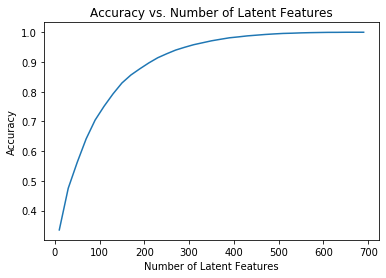

In [355]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [424]:
df.article_id = df.article_id.astype(float)
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''    
    
    df_train.loc[:, 'views'] = 1
    user_item_train = df_train.groupby(['user_id', 'article_id']).views.min().unstack()
    user_item_train.fillna(0, inplace=True)

    df_test.loc[:, 'views'] = 1
    user_item_test = df_test.groupby(['user_id', 'article_id']).views.min().unstack()
    user_item_test.fillna(0, inplace=True)
    
    test_arts = df_test.article_id.unique()
    test_idx = df_test.user_id.unique()
   
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [483]:
print(f"we can make predictions for {len(np.intersect1d(user_item_train.index, user_item_test.index))} users in the test set")
print(f"we cannot make predictions for {len(np.setdiff1d(user_item_test.index, user_item_train.index))} users")
print(f"we can make predictions for {len(np.intersect1d(user_item_train.columns, user_item_test.columns))} articles in the test set")
print(f"we cannot make predictions for {len(np.setdiff1d(user_item_test.columns, user_item_train.columns))} articles")

we can make predictions for 20 users in the test set
we cannot make predictions for 662 users
we can make predictions for 574 articles in the test set
we cannot make predictions for 0 articles


In [499]:
# Replace the values in the dictionary below
a = 662 
b = 574
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?':  c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

KeyError: 'How many movies can we make predictions for in the test set?'

# FINDING MISTAKES IN sol_4_test:

The wording in the project_tests.py doesn't match the wording proposed above in this notebook. So it is impossible to pass this test, no matter what letters (even correct ones) you put in!!!! <br>

See below:

The solution asks us in questions 3 and 4 "How many **MOVIES** ...":

In [488]:
sol_4_dict_1 = {
'How many users can we make predictions for in the test set?': c, 
'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
'How many movies can we make predictions for in the test set?': b,
'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

The notebook asks us in questions 3 and 4 "How many **ARTICLES** ...":

In [500]:
sol_4_dict = {
    'How many users can we make predictions for in the test set?':  c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [760]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train =  np.linalg.svd(user_item_train, full_matrices=True)
# fit svd similar to above then use the cells below

In [761]:
print(f"We know that we can make predictions for {len(np.intersect1d(user_item_train.columns, user_item_test.columns))} articles and for {len(np.intersect1d(user_item_train.index, user_item_test.index))} users. Let's subset the test data")

We know that we can make predictions for 574 articles and for 20 users. Let's subset the test data


In [762]:
#we can make predictions only for these user_ids
users_pred = np.intersect1d(user_item_train.index, user_item_test.index)
#we can make predictions only for these articles
article_pred = np.intersect1d(user_item_train.columns, user_item_test.columns)

# filter test_subset - leave only users for whom we can make preds
test_subset = user_item_test.loc[users_pred, article_pred]
print("shape of test_subset", test_subset.shape)

shape of test_subset (20, 574)


In [763]:
# find index positions for users for whom we can make predictions
user_pred_idx = []
train_users = df_train['user_id'].sort_values().unique()
for user_id in users_pred:
    user_pred_id = np.where(train_users==user_id)[0].tolist()[0]
    user_pred_idx.append(user_pred_id)
print("indices of users for whom we can make predictions", user_pred_idx)

indices of users for whom we can make predictions [2916, 3023, 3092, 3192, 3526, 3531, 3683, 3739, 3776, 3800, 3967, 3988, 3989, 3997, 4001, 4203, 4230, 4273, 4292, 4486]


In [764]:
# find index positions for articles for which we can make predictions
art_pred_idx = []
train_arts = df_train['article_id'].sort_values().unique()
for article_id in article_pred:
    art_pred_id = np.where(train_arts==article_id)[0].tolist()[0]
    art_pred_idx.append(art_pred_id)
print("the last 10 indices of articles for which we can make predictions", art_pred_idx[-10:])

the last 10 indices of articles for which we can make predictions [702, 703, 704, 705, 706, 707, 708, 709, 710, 712]


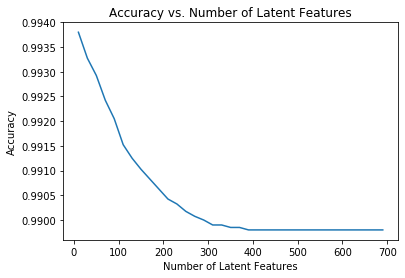

In [765]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    #filter user_item_est to include only users and articles for whom/which we can make predictions
    user_item_est_filt = user_item_est[user_pred_idx, :][:, art_pred_idx]
    # compute error for each prediction to actual value
    diffs = np.subtract(test_subset, user_item_est_filt)
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df_train.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [769]:
def predict_interaction(user_id, article_id, k=400):
    '''
    INPUT:
    user_id - the user_id from the df_test
    article_id - the article_id according the df_test
    
    OUTPUT:
    pred - the predicted rating for user_id-article_id according to SVD
    '''
    # Use the training data to create a series of users and articles that matches the ordering in training data
        #serious mistake to avoid - i didn't sort_values in the first attempt, so the location was mismatched. 
        #we actually created user-by-movie matrix train_data_df that is the base for our ratings_mat 
        # so either sort_values on train_df
        # or use train_data_df.index and train_data_df.columns as in the solution
        
    train_users = df_train['user_id'].sort_values().unique()
    train_arts = df_train['article_id'].sort_values().unique()
        
    # User row and article column
    n = np.where(train_users==user_id)[0]
    m = np.where(train_arts==article_id)[0]
    
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(np.dot(u_new[n, :], s_new), vt_new[:, m])[0][0]
   
    return pred

Let's see how well we can predict 1s:

In [770]:
#filter test_subset to have only values that equal 1
subset_1s = []
for user in test_subset.index:
    for article in test_subset.columns:
        if test_subset.loc[user, article] == 1:
            subset_1s.append((user, article))
            
print(f"there are {len(subset_1s)} values that equal 1 in test_subset, i.e. users for whom we can make predictions in the test set")
print(f"these corresponds to {round(len(subset_1s)/test_subset.size*100, 2)}% of the test subset")

there are 218 values that equal 1 in test_subset, i.e. users for whom we can make predictions in the test set
these corresponds to 1.9% of the test subset


In [772]:
#let's validate how well we can predict 1s:
print("user \t\t article \t actual \t predicted")
actual = np.ones((len(subset_1s), 1), dtype=int)[0][0]
for tup in subset_1s:
    user = tup[0]
    article = tup[1]
    pred = predict_interaction(user, article, k=500)
    print(f"{user:4d} \t\t {int(article):4d} \t\t {actual:1d} \t\t {np.abs(pred):.01f}")

user 		 article 	 actual 	 predicted
2917 		  647 		 1 		 0.0
2917 		  965 		 1 		 0.0
3024 		   12 		 1 		 0.0
3024 		   43 		 1 		 1.0
3024 		   74 		 1 		 0.0
3024 		  194 		 1 		 0.0
3024 		  241 		 1 		 0.0
3024 		  316 		 1 		 0.0
3024 		 1351 		 1 		 0.0
3093 		  151 		 1 		 0.0
3093 		  194 		 1 		 0.0
3093 		  957 		 1 		 0.0
3093 		 1017 		 1 		 1.0
3093 		 1436 		 1 		 0.0
3193 		  362 		 1 		 0.0
3193 		  939 		 1 		 0.0
3193 		 1051 		 1 		 0.0
3193 		 1410 		 1 		 0.0
3193 		 1427 		 1 		 0.0
3527 		  109 		 1 		 0.0
3532 		   12 		 1 		 0.0
3532 		   43 		 1 		 1.0
3532 		   50 		 1 		 0.0
3532 		  116 		 1 		 0.0
3532 		  130 		 1 		 0.0
3532 		  131 		 1 		 0.0
3532 		  278 		 1 		 0.0
3532 		  297 		 1 		 0.0
3532 		  310 		 1 		 0.0
3532 		  323 		 1 		 0.0
3532 		  409 		 1 		 0.0
3532 		  415 		 1 		 0.0
3532 		  482 		 1 		 0.0
3532 		  695 		 1 		 0.0
3532 		  844 		 1 		 0.0
3532 		  898 		 1 		 0.0
3532 		  981 		 1 		 0.0
3532 		 1024 		 1 		 0.0
3532 		 1051 

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**We made predictions on user-articles interactions using SVD approach, where 0s meant no iteractions and 1s meant an interaction. Because of our test and train sets overlapped only for 20 users and 574 articles, we had to limit our original test to the matrix of these values. The predicted accuracy turned out to be extremely high (over 0.99). But when we actually looked how predictions were made for positive instance (i.e. 1s or interactions), it turned out that we're mostly mispredict them. <br>
Thus we encountered the well known class imbalance problem here. Given a highly class imbalances in our dataset (only 1.9% of values in test subset were 1s), it makes sense to predict 0s and we'll be correct most of the time. So we can't really rely on high accuracy scores and need to deal with class imbalance problem first. <br>
Another possible solution is to try FunkSVD approach which is based on gradient descent and unlike classical SVD approach can handle Nans. So we might not need to recode our data and try as well working with the original number of user-article iteractions (instead of 0s and 1s). 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])